# Maximum Clique via Integer Programming
This notebook formulates the Maximum Clique problem as a binary integer program and solves it using PuLP (an LP/IP solver in Python). 

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import pulp
import random

## The Maximum Clique Problem

A **clique** in an undirected graph $G=(V,E)$ is a subset of vertices $C\subseteq V$ such that every pair of vertices in $C$ is connected by an edge.

**Problem statement:**  
Find the largest clique  
$$
C^* = \arg\max_{C\subseteq V} \lvert C\rvert
\quad\text{subject to}\quad
\{i,j\}\in E\quad\forall\,i,j\in C.
$$

**Integer programming formulation:**

1. **Variables**  
   For each vertex $i\in V$, introduce a binary variable  
   $$
   x_i = 
   \begin{cases}
     1, & \text{if vertex }i\text{ is in the clique},\\
     0, & \text{otherwise}.
   \end{cases}
   $$

2. **Objective**  
   Maximize the total number of selected vertices:  
   $$
   \max \sum_{i\in V} x_i
   $$

3. **Clique constraints**  
   For every pair of vertices $\{i,j\}\notin E$ (i.e. a non‐edge), ensure at most one is chosen:  
   $$
   x_i + x_j \le 1
   \quad\forall\,\{i,j\}\notin E.
   $$

4. **Binary constraints**  
   $$
   x_i \in \{0,1\}
   \quad\forall\,i\in V.
   $$

When solved optimally, the set $\{\,i: x_i=1\}$ is a maximum‐cardinality clique of $G$.


## Solver Implementation
We define a function `max_clique_ip(G)` that builds and solves the IP, returning the clique nodes.

In [2]:
def max_clique_ip(G):
    # Create the problem
    prob = pulp.LpProblem('MaxClique', pulp.LpMaximize)
    # Binary variables for each node
    x = {i: pulp.LpVariable(f'x_{i}', cat='Binary') for i in G.nodes()}

    # Objective: maximize sum of x_i
    prob += pulp.lpSum(x[i] for i in G.nodes())

    # Constraints: for each non-edge, x_i + x_j <= 1
    non_edges = nx.non_edges(G)
    for i, j in non_edges:
        prob += x[i] + x[j] <= 1

    # Solve
    prob.solve(pulp.PULP_CBC_CMD(msg=False))

    # Extract clique
    clique = [i for i in G.nodes() if pulp.value(x[i]) > 0.5]
    return clique


## Example 1: Zachary's Karate Club
The network has 34 nodes and represents friendship ties in a karate club. We find its maximum clique.

Karate club max clique size: 5
Nodes in clique: [0, 1, 2, 3, 7]


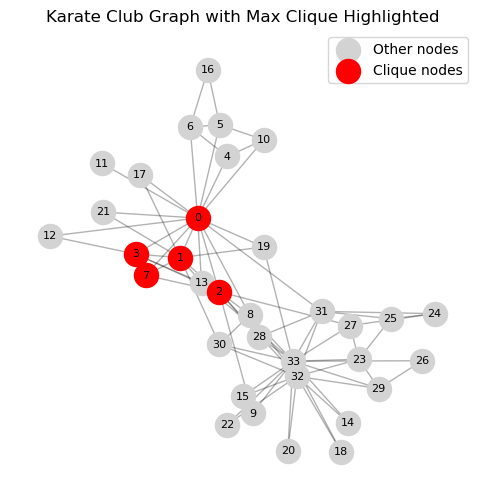

In [3]:
# Load graph
G_karate = nx.karate_club_graph()
# Solve
clique_karate = max_clique_ip(G_karate)
print('Karate club max clique size:', len(clique_karate))
print('Nodes in clique:', clique_karate)

# Visualization
pos = nx.spring_layout(G_karate, seed=42)
plt.figure(figsize=(6,6))
nx.draw_networkx_edges(G_karate, pos, alpha=0.3)
nx.draw_networkx_nodes(
    G_karate, pos,
    nodelist=[n for n in G_karate.nodes() if n not in clique_karate],
    node_color='lightgray', node_size=300,
    label='Other nodes'
)
nx.draw_networkx_nodes(
    G_karate, pos,
    nodelist=clique_karate,
    node_color='red', node_size=300,
    label='Clique nodes'
)
nx.draw_networkx_labels(G_karate, pos, font_size=8)
plt.title('Karate Club Graph with Max Clique Highlighted')
plt.legend(scatterpoints=1)
plt.axis('off')
plt.show()


## Example 2: Random Erdős–Rényi Graphs
We generate random graphs with 20 nodes and edge probability 0.3, solve, and plot one instance.

Random graph max clique size: 4


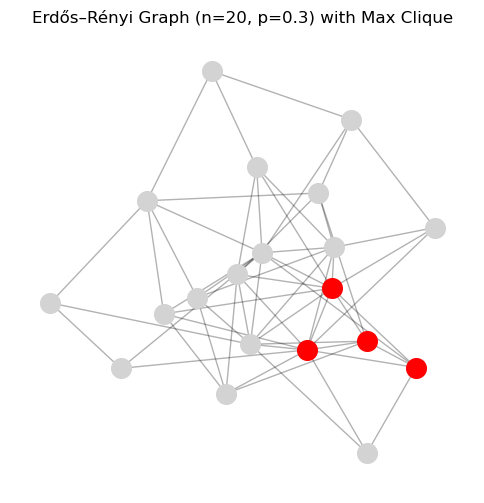

In [4]:
# Generate random graph
random.seed(1)
G_rand = nx.erdos_renyi_graph(n=20, p=0.3, seed=1)
clique_rand = max_clique_ip(G_rand)
print('Random graph max clique size:', len(clique_rand))

# Visualization
pos_rand = nx.spring_layout(G_rand, seed=42)
plt.figure(figsize=(6,6))
nx.draw_networkx_edges(G_rand, pos_rand, alpha=0.3)
nx.draw_networkx_nodes(G_rand, pos_rand, nodelist=[n for n in G_rand.nodes() if n not in clique_rand],
                       node_color='lightgray', node_size=200)
nx.draw_networkx_nodes(G_rand, pos_rand, nodelist=clique_rand,
                       node_color='red', node_size=200)
plt.title('Erdős–Rényi Graph (n=20, p=0.3) with Max Clique')
plt.axis('off')
plt.show()


## Discussion
- The IP formulation using binary variables and non-edge constraints finds the true maximum clique.
- For the Karate Club graph, we observe the largest fully connected community.
- On random graphs, clique sizes tend to be much smaller (around size ~4–5 for p=0.3, n=20).
- Integer programming scales to moderate sizes (30–50 nodes) but may become slow for larger graphs due to exponential complexity.